In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from pylab import imshow, show
from numba import jit, cuda
import cmath # complex numbers

# to measure exec time
from timeit import default_timer as timer

In [37]:
 #%matplotlib inline

## First example : Pi calculation (Monte-Carlo method)


The ratio of the circle area to the square area is 

$$\frac{A_c}{A_s} = \frac{\pi R^2}{L^2} = \pi / 4 = \frac{\text{number of points generated inside the circle}}{\text{number of points generated inside the square}}$$

So if we can estimate this ratio, we can estimate pi (with relative precision). And to estimate this ratio, we will simply shoot a large number of points in the square (like darts game), following a uniform probability distribution. The fraction of the points falling in the circle is an estimator of r. Obviously, the more points, the more precise this estimator will be, and the more decimals of pi can be computed. 
Let's implement this method, and use it with an increasing number of points to see how the precision improves. 

In [20]:
def monte_carlo_pi(nsamples):
    circle_points = 0
    square_points = 0
    for i in range(nsamples):
        x = random.uniform(-1,1) # Return the random number with floating comma in the range [0.0, 1.0)
        y = random.uniform(-1,1)
        if (x**2 + y**2) < 1:
            circle_points += 1
        square_points += 1
        pi = 4.0 * circle_points / square_points
    return pi

In [22]:
start = timer()
monte_carlo_pi(10000000)
print('running time without Numba: ' , timer()-start)

running time without Numba:  9.340675861996715


A few seconds for 10 million points. This algorithm is O(N), so if we want to use 1 **billion** points, it will take us around 10 minutes. 

In [23]:
@jit # Tell numba to just-in-time compile your function
def monte_carlo_pi_fast(nsamples):
    circle_points = 0
    square_points = 0
    for i in range(nsamples):
        x = random.uniform(-1,1) # Return the random number with floating comma in the range [0.0, 1.0)
        y = random.uniform(-1,1)
        if (x**2 + y**2) <= 1:
            circle_points += 1
        square_points += 1
        pi = 4.0 * circle_points / square_points
    return pi

In [24]:
start = timer()
monte_carlo_pi_fast(10000000)
print('running time with Numba: ' , timer()-start)

running time with Numba:  0.2768302729964489


Quite amazing ! here we use 10.000.000 shots

## Second example : basic numpy array calculation

In [9]:
# normal function to run on cpu
def func(a):                                
    for i in range(10000000):
        a[i]+= 1      

# the same function decorated with numba
@jit                         
def func2(a):
    for i in range(10000000):
        a[i]+= 1
        

n = 10000000                            
a = np.ones(n, dtype = np.float64) # a big numpy array with 10 millions of values
      
start = timer()
func(a)
print("without Numba:", timer()-start)    
      
start = timer()
func2(a)
print("with Numba:", timer()-start)

without Numba: 5.976175371000863
with Numba: 0.07959248599945568


## 3. Fractal : Mandelbrot and Julia sets



### 3.1 Julia set


Julia set comes from the study of complex equation $z_{n+1} = z_n^2 + c$ and is defined by the ensemble $\{z \in \mathbb{C} \; |\; |z^2 + c| < R   \}$ for some $R$ fixed. 

- Julia set is defined by the iteration : $z \rightarrow z^2 +c$ with $z_0 = 0$ and $c = $ constant. For Julia sets, c is the same complex number for all pixels, and there are many different Julia sets based on different values of c. 

In [32]:
# Image width and height are the parameters for the plot
#im_width, im_height = 1024, 1024
#c is constant complex number
#R is the max module value
#iter_max is the maximum number of iterations before z_n is considered divergent
@jit
def julia_set(im_width,im_height,c, R, iter_max):

    # def of parameters of image as a numpy array
    x = np.linspace(-1.5, 1.5, im_width) # complex real axis run from -1.5 to 1.5
    y = np.linspace(-1.5, 1.5, im_height) # complex imaginary axis run from -1.5 to 1.5
    image = np.zeros((im_width, im_height)) # x.size = im_width and y.size = im_height by definition

    for i in range(im_width):
        for j in range(im_height):
            n = 0
            # Map pixel position to a point in the complex plane
            z = x[i] + 1j*y[j]
        
            # Do the iterations
            while abs(z) <= R and n < iter_max:
                z = z**2 + c
                n += 1
            image[j,i] = n
    
    return image

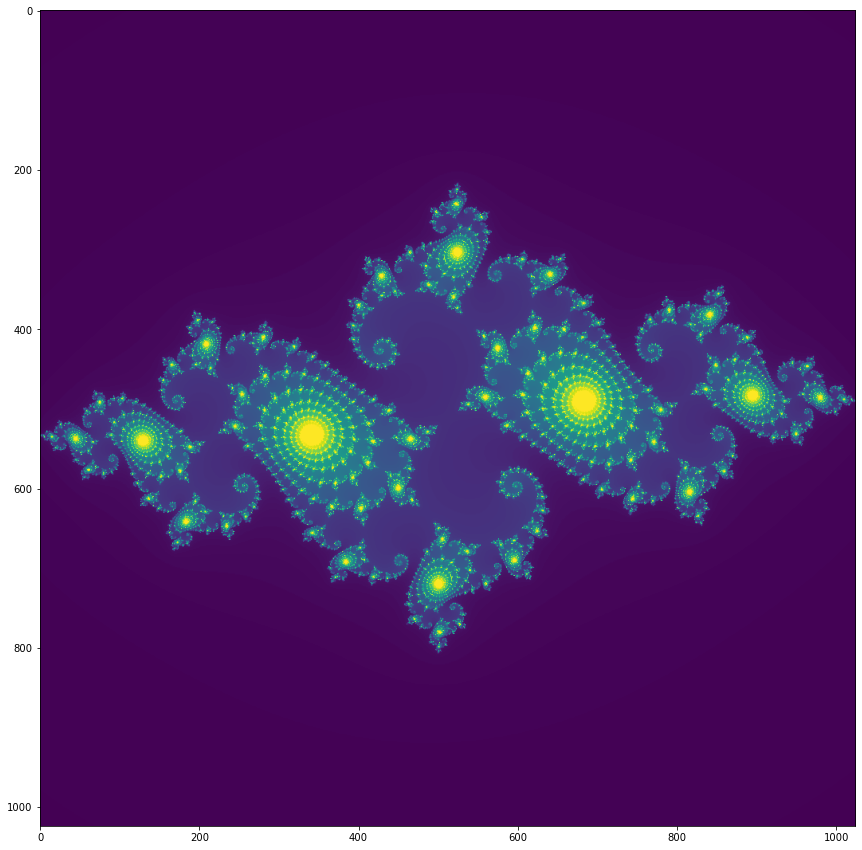

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(julia_set(im_width=1024, im_height=1024, c=complex(-0.75,0.125), R=4, iter_max=200))

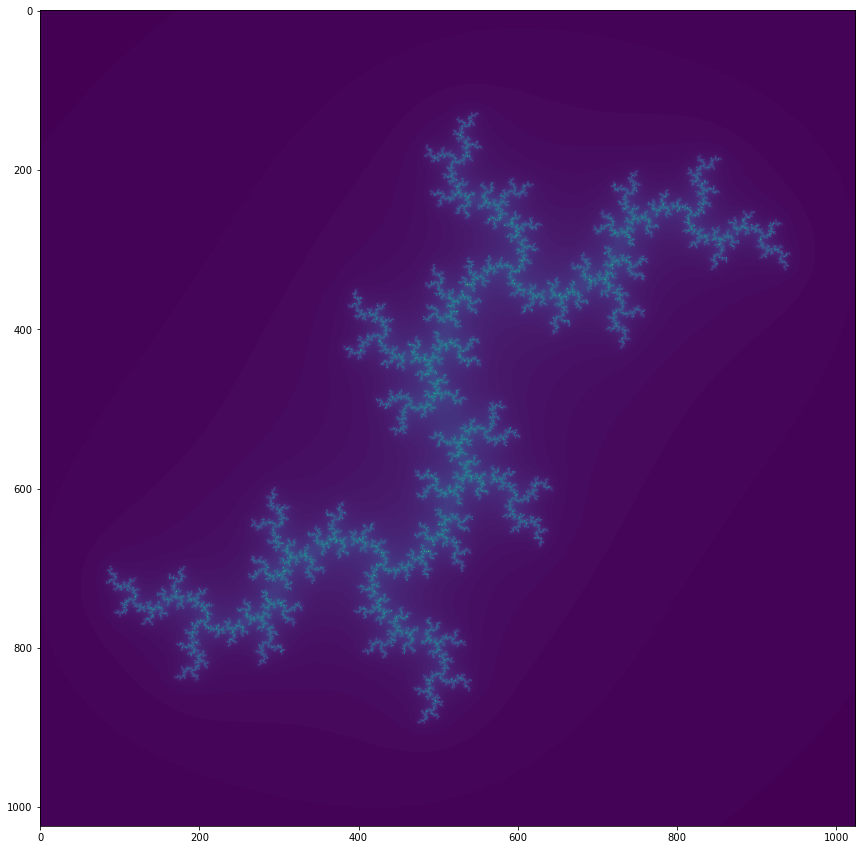

In [34]:
plt.figure(figsize=(15,15))
plt.imshow(julia_set(im_width=1024, im_height=1024, c=complex(0,0.8), R=4, iter_max=200))

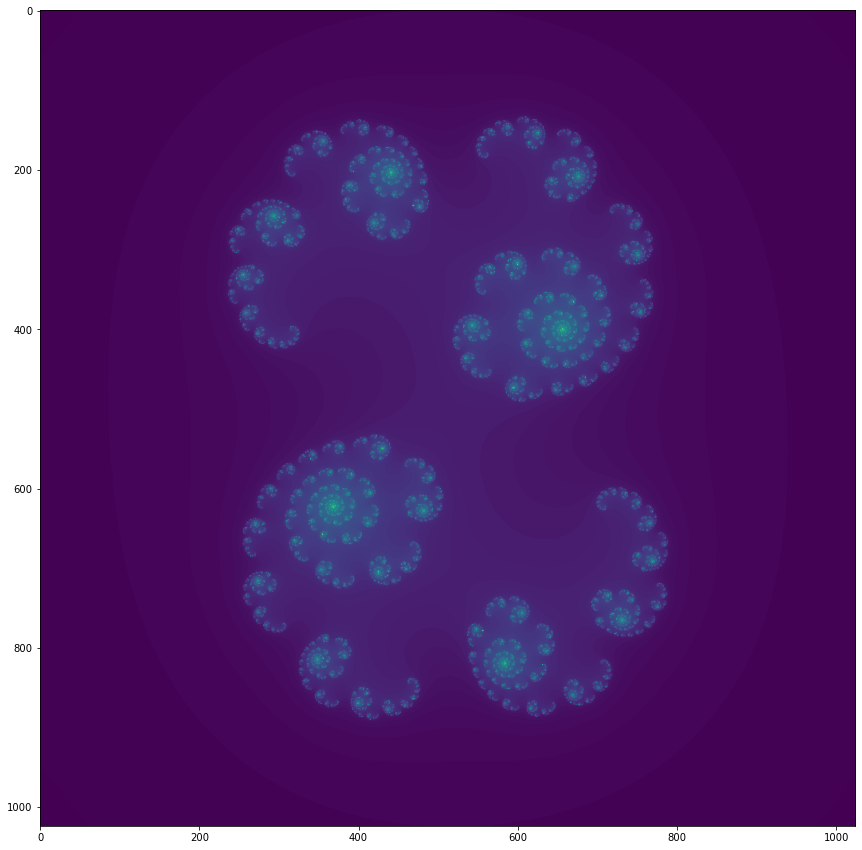

In [36]:
plt.figure(figsize=(15,15))
plt.imshow(julia_set(im_width=1024, im_height=1024, c=complex(0.35,-0.05), R=4, iter_max=200))

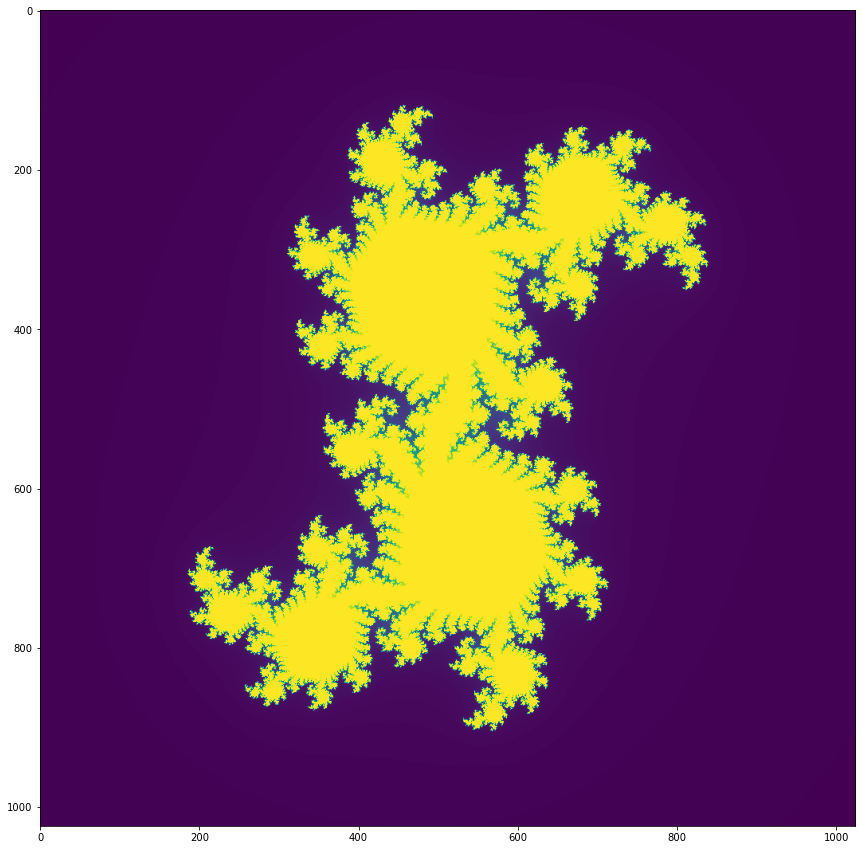

In [37]:
plt.figure(figsize=(15,15))
plt.imshow(julia_set(im_width=1024, im_height=1024, c=complex(0.35,0.35), R=4, iter_max=200))

**Remark** : A colored image is usually represented by a 3D array of size (pixels_x, pixels_y, 3) fpr example (1024,1024,3) for a 1024 * 1024 image. 
That is a 3D numpy array (a 3D matrix!). But here you remarked that we have only 1D: we should have use a parameter cmap = gray, as these are monochrome images.
But for visualization, imshow automatically put some color to identify pixels with different values.

### 3.2 Mandelbrot set


- Mandelbrot set is defined by $\{c \in \mathbb{C} \; | \; z_{n+1} = z_n^2 + c \;\;\text{is bounded, that is} \;|z_n| < R \}$ for some $R$ fixed. Here the parameter c varies.

In other words, the Mandelbrot set is the set of complex numbers c for which the function $f(z) = z^2 + c$ doesn't diverge when iterated from z = 0, i.e., for which the sequence
    f(0), f(f(0)), etc., remains bounded in absolute value. One prove that a sufficient condition for divergence is $|z_n| > 4$.


For the Mandelbrot set, c instead differs for each pixel and is x + yi, where x and y are the image coordinates (as was also used for the initial z value). The Mandelbrot set can be considered a map of all Julia sets because it uses a different c at each location, as if transforming from one Julia set to another across space.

In [6]:
@jit # Tell numba to just-in-time compile your function
def mandel(c, R, iter_max):
    z = complex(0,0)
    for n in range(iter_max):
        z = z**2 + c
        if abs(z) >= R:
            break
    return n

@jit # Tell numba to just-in-time compile your function
def mandel_set(im_width,im_height, R, iter_max):

    x = np.linspace(-2.0, 1.0, im_width) # complex real axis run from -1.5 to 1.5
    y = np.linspace(-1.5, 1.5, im_height) # complex imaginary axis run from -1.5 to 1.5
    image = np.zeros((im_width, im_height)) # x.size = im_width and y.size = im_height by definition
        
    for i in range(im_width):
        for j in range(im_height):
            n = 0
            c = x[i] + 1j*y[j]

            image[j,i] = mandel(c, R, iter_max)
    
    return image

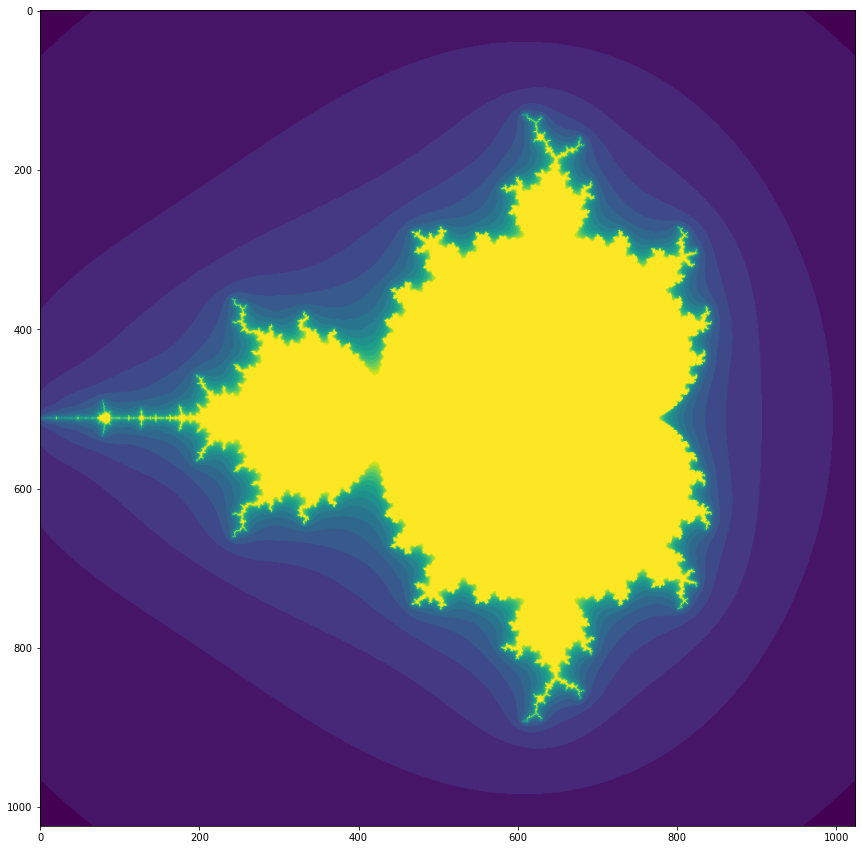

In [4]:
img = mandel_set(im_width=1024, im_height=1024, R=4, iter_max=20)
plt.figure(figsize=(15,15))
plt.imshow(img)

In [73]:
img.shape

(1024, 1024)

In [76]:
img

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [78]:
np.unique(img,return_counts = True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.]),
 array([  7488, 336322, 223068, 101154,  54474,  33148,  21910,  15426,
         11428,   8686,   6848,   5488,   4524,   3688,   3168,   2710,
          2310,   2068, 204668]))

Now augment the number of pixels in order to visualize same patterns at different scales

In [7]:
import ipywidgets as widgets
#to zoom : release matplotlib widget, and mark #%matplotlib inline
%matplotlib widget

In [8]:
img = mandel_set(im_width=4000, im_height=4000, R=4, iter_max=20)
plt.figure(figsize=(15,15))
plt.imshow(img)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Other methods to plot Julia and Mandelbrot sets

The code is taken from the book 'Make your own Mandelbrot' by Tariq Rashid

In [25]:
# mandelbrot function - takes the fixed parameter c and the maximum number of iterations maxiter as inputs

def mandel(c, maxiter):
    # starting value of complex number z is 0 + 0i before the iterations update it
    z = complex(0, 0)
    # start iterating and stop when it reaches maxiter times
    for iteration in range(maxiter):
        
        # the main function which generates the output value of z from the input values using the formula (z^2) + c 
        z = (z * z) + c    
    # check if the (pythagorean) magnitude of the output complex number is greater than 4, if so stop iterating
        # as we've diverged already
        if abs(z) > 4:
            break
            
    # number of iterations (not the value of z), as this tells us how quickly the values diverged past the 
    # magnitude threshold of 4
    return iteration

In [26]:
def draw_mandel_at(xvalues, yvalues, const):
    # size of these lists of x and y values
    xlen = len(xvalues)
    ylen = len(yvalues)

    # # create an array of the right size to represent the atlas, we use the number of items in xvalues and yvalues
    atlas = np.empty([xlen, ylen])

    # go through each point in this atlas array and test to see how many
    # iterations are needed to diverge (or reach the maximum iterations
    # when not diverging)
    for ix in range(xlen):
        for iy in range(ylen):
            
            # at this point in the array, work out what the actual real
            # and imaginary parts of x are by looking it up in the xvalue and
            # yvalue lists
            cx = xvalues[ix]
            cy = yvalues[iy]
            c = complex(cx, cy)
        
            # # now we know what c is for this place in the atlas, apply
            # the mandel() function to return the number of iterations it took to
            # diverge

            atlas[ix, iy] = mandel(c, const)

    return atlas

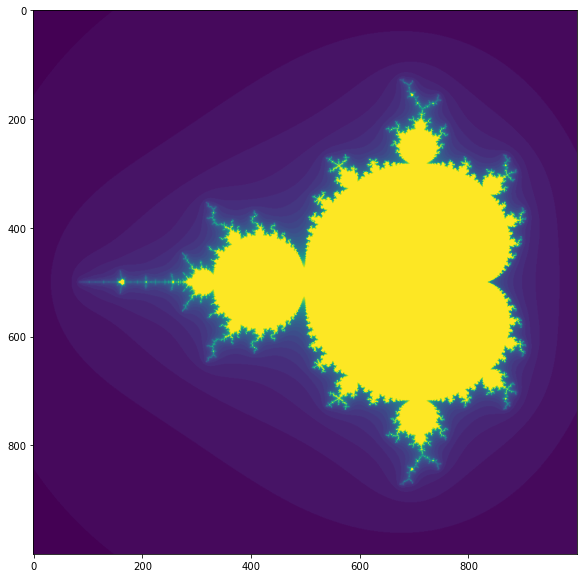

In [27]:

# set the location and size of the complex plane rectangle
xvalues = np.linspace(-2.25, 0.75, 1000)
yvalues = np.linspace(-1.5, 1.5, 1000)

atlas = draw_mandel_at(xvalues, yvalues, 40)

plt.figure(figsize=(10, 10))
    
# # plot the array atlas as an image, with its values represented as
# colours, peculiarity of python that we have to transpose the array
plt.imshow(atlas.T)

In [68]:

def julia(z, c, maxiter):
    # start iterating and stop when it reaches maxiter times
    for iteration in range(maxiter):
        
        # the main function which generates the output value of z from the input values using the formula (z^2) + c 
        z = (z * z) + c
        
        # check if the (pythagorean) magnitude of the output complex number is greater than 4, if so stop iterating
        # as we've diverged already
        if abs(z) > 4:
            break
            
    # number of iterations (not the value of z), as this tells us how quickly the values diverged past the 
    # magnitude threshold of 4
    return iteration

In [69]:
def draw_julia_at(xvalues, yvalues, const, c):
    # size of these lists of x and y values
    xlen = len(xvalues)
    ylen = len(yvalues)
    
    # # create an array of the right size to represent the atlas, we use the number of items in xvalues and yvalues
    atlas = np.empty([xlen, ylen])

    # go through each point in this atlas array and test to see how many
    # iterations are needed to diverge (or reach the maximum iterations
    # when not diverging)
    for ix in range(xlen):
        for iy in range(ylen):
            
            # at this point in the array, work out what the actual real
            # and imaginary parts of x are by looking it up in the xvalue and
            # yvalue lists
            zx = xvalues[ix]
            zy = yvalues[iy]
            z = complex(zx, zy)
        
            # # now we know what c is for this place in the atlas, apply
            # the mandel() function to return the number of iterations it took to
            # diverge

            atlas[ix, iy] = julia(z, c, const)

    return atlas

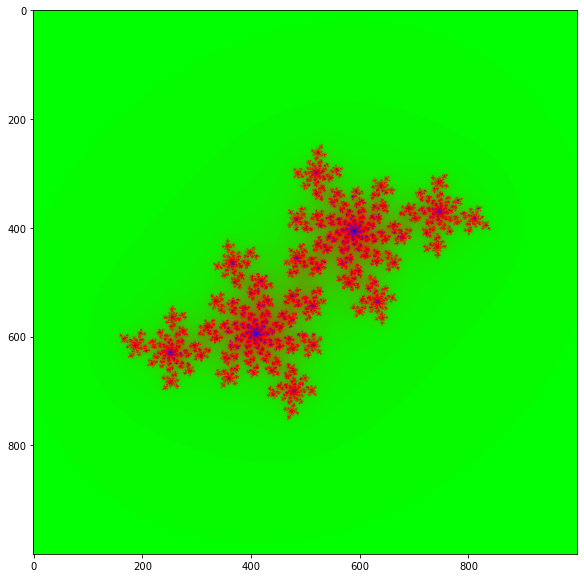

In [70]:
# set the location and size of the atlas rectangle
xvalues = np.linspace(-2, 2 , 1000)
yvalues = np.linspace(-2, 2 , 1000)

# value of c (unique for each Julia set)
c = complex(-0.35, 0.65)

atlas = draw_julia_at(xvalues, yvalues, 120, c)

# plot the array atlas as an image, with its values represented as
# colours, peculiarity of python that we have to transpose the array
plt.figure(figsize=(10, 10))
plt.imshow(atlas.T, cmap='brg_r')
# parameters of cmap : hsv, gnuplot2_r,gist_rainbow, brg,gnuplot2

Other fractals coming soon : Magnetic, Newton, Nova,...